In [1]:
%matplotlib inline

import os
import psycopg2
import seaborn as sns
import pandas as pd
import random
import numpy as np
# from ggplot2 import *

import datetime
from matplotlib import pyplot as plt
from dateutil import relativedelta
from __future__ import division

from pymongo import MongoClient

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

os.sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from shared.coverage_charts import exploration
from shared.corr_charts import plot
from shared.fill_charts import plot_fill

## Log into PSQL
DB_NAME = os.environ['DB_NAME']
DB_HOST = os.environ['DB_HOST']
DB_USER = os.environ['DB_USER']
DB_PASS = os.environ['DB_PASS']
credentials = (DB_NAME, DB_USER, DB_HOST, DB_PASS)
psql = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s' options='-c statement_timeout=200000'" % credentials)

## Log into redshift. 
#RED_NAME = os.environ['REDSHIFT_NAME']
#RED_HOST = os.environ['REDSHIFT_HOST']
#RED_USER = os.environ['REDSHIFT_USER']
#RED_PASS = os.environ['REDSHIFT_PASS']
#RED_PORT = os.environ['REDSHIFT_PORT']
#r_credentials = (RED_NAME, RED_USER, RED_HOST, RED_PASS, RED_PORT)
#rpsql = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s' port='%s'" % r_credentials)

## Log into Mongo.
#USER = os.environ['MONGO_USER']
#PASS = os.environ['MONGO_PASS']
#HOST = os.environ['MONGO_HOST']
#DB = os.environ['MONGO_NAME']
#credentials = (USER, PASS, HOST, DB)


### Step 0: Look at how the data is aggregated, does it make sense?
(Document on confluence)
Examples:
* How is matching done (by website?)
* Is there any double counting?
* Are averages, differences done correctly?

In [2]:
# Current year and month (used to get mappings and company info)
curr_year = 2018
curr_month = 5

curr_month_str = str(curr_month)
if len(curr_month_str) == 1:
    curr_month_str = '0' + curr_month_str 

In [3]:
# Loading data from mongo

# How to normalize nested mongo data
# mongo = MongoClient('mongodb://%s:%s@%s:27017/raw?authSource=%s' % credentials).db.article.find({})
# data = pd.io.json.json_normalize(list(mongo))

# Examples of how to sample and query with a conditional
# db.article.aggregate([{"$sample": {"size": 100000}}])
# db.article.aggregate([{"$match": {"processing_month":"2017-07"}}, {"$limit": 1000000}])

In [6]:
# Loading data from psql or redshift
query = 'SELECT * FROM clean_monthly_v3.email_dkim_agg WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
data = pd.read_sql_query(query, psql)

Check the structure of the table.

Metadata: https://cyence.atlassian.net/wiki/spaces/DS/pages/99633412/Data+ID+26+-+Email+DKIM

In [7]:
data.columns.values

array(['run_date', 'last_updated', 'cyence_id', 'agg_cnt',
       'total_records_cnt', 'max_public_key_length',
       'min_public_key_length', 'duration'], dtype=object)

In [8]:
data.min_public_key_length.unique() # look at the data

array([   0,  576,  640,  768,  896,  704,  832, 1088, 1152, 1472, 1216,
       1024, 1280,  960, 1344, 4928, 1792, 1856, 1536])

### Step 1: Look at fill rate and document fields (cardinality, etc)

In [9]:
df = data
null = []
empty = []
nrows = len(df)

for col in df.columns.values:
    if not isinstance((df[col].values[0]), (float, int)):
        empty.append((len(df[df[col] == ""]))/nrows)
    else:
        empty.append(0)
    null.append((len(df[df[col].isnull()]))/nrows)

fill = pd.DataFrame()
fill['column_name'] = df.columns.values
fill['null'] = null
fill['empty_string'] = empty
fill['value'] = 1 - fill['null'] - fill['empty_string']
print fill

# To make a graph with fill information (useful when mixture of empty strings and null):
# plot_fill.make_fill_chart(data)

             column_name  null  empty_string  value
0               run_date   0.0           0.0    1.0
1           last_updated   0.0           0.0    1.0
2              cyence_id   0.0           0.0    1.0
3                agg_cnt   0.0           0.0    1.0
4      total_records_cnt   0.0           0.0    1.0
5  max_public_key_length   0.0           0.0    1.0
6  min_public_key_length   0.0           0.0    1.0
7               duration   0.0           0.0    1.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557029 entries, 0 to 557028
Data columns (total 8 columns):
run_date                 557029 non-null object
last_updated             557029 non-null object
cyence_id                557029 non-null int64
agg_cnt                  557029 non-null int64
total_records_cnt        557029 non-null int64
max_public_key_length    557029 non-null int64
min_public_key_length    557029 non-null int64
duration                 557029 non-null int64
dtypes: int64(6), object(2)
memory usage: 34.0+ MB


### Step 2: Look at variable distributions & relationships (this section is open-ended)


 Things to look at (if applicable):
 * Common catagorical values 
 * Seasonality/year over year trends
 * Range, bounded or unbounded?
 * Boxplot/histogram/PDF. Single modal or multiple modals?
 * Conditioning plot (if there are categorical variables or range of continuous variables to control)  http://geog.uoregon.edu/GeogR/topics/coplots.html
 
https://ft-interactive.github.io/visual-vocabulary/


In [11]:
# Create coverage plots
cyids_info, er_info = exploration.get_revenue_and_sector(data['cyence_id'].unique(), datetime.datetime(curr_year, curr_month, 1))

Retrieving ER information from company_info
Retrieving ER information from company_info_eu
Retrieving ER information from company_info_jp


In [12]:
cyids_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537047 entries, 0 to 537050
Data columns (total 5 columns):
cyence_id        537047 non-null int64
revenue          537047 non-null float64
cyence_sector    536939 non-null object
geo              537047 non-null int64
revenue_label    537047 non-null category
dtypes: category(1), float64(1), int64(2), object(1)
memory usage: 21.0+ MB


Now let's merge two datasets together.

In [13]:
# inner join DKIM data with company info
new_data = pd.merge(data, cyids_info, on = ["cyence_id", "cyence_id"])
new_data.info()

# new_data.agg_cnt.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537047 entries, 0 to 537046
Data columns (total 12 columns):
run_date                 537047 non-null object
last_updated             537047 non-null object
cyence_id                537047 non-null int64
agg_cnt                  537047 non-null int64
total_records_cnt        537047 non-null int64
max_public_key_length    537047 non-null int64
min_public_key_length    537047 non-null int64
duration                 537047 non-null int64
revenue                  537047 non-null float64
cyence_sector            536939 non-null object
geo                      537047 non-null int64
revenue_label            537047 non-null category
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 49.7+ MB


Look at the relationship between `total_records_cnt` (the number of DKIMs found for websites associated with cyence ID) and revenue (log scale).

**Conclusion:**

- There is no linear relationship between the two.
- Generally speaking, a larger company seems to have more DKIM records.

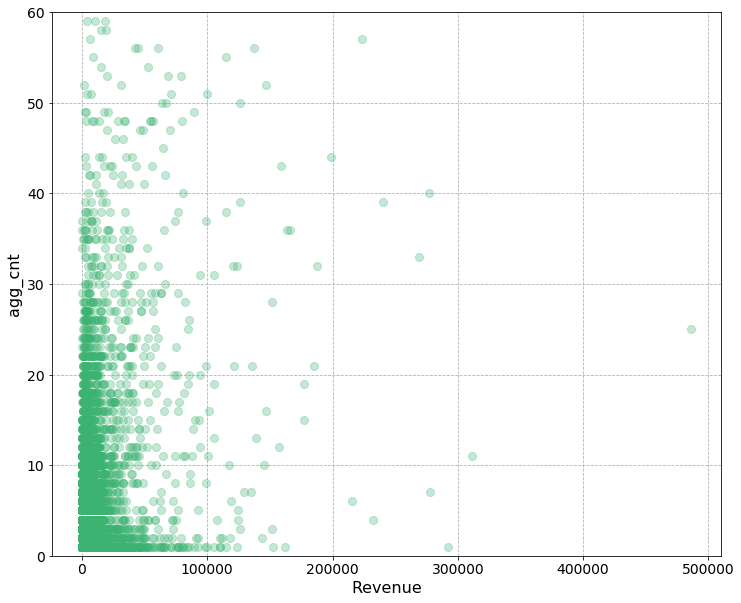

In [14]:
# Scatter plot
plt.figure(figsize = (12, 10))
# plt.plot(new_data['revenue'], new_data['agg_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 10)
plt.plot(new_data['revenue'] , new_data['agg_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 8)

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("agg_cnt", fontsize = 16) 
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim((0, 60))
plt.grid(ls = "--")

# plt.savefig("revenue_agg_cnt.png")

### Step 3: Coverage

In [15]:
# If data need to be aggregated from DUNS level
query = 'SELECT cyence_id, duns_key FROM get_mappings(\'%s-%s-01\');' % (str(curr_year), curr_month_str)
mappings = pd.read_sql_query(query, psql)
agg_data = pd.merge(mappings, new_data, on = ["cyence_id", "cyence_id"])

In [16]:
agg_data["public_key"] = np.where(agg_data["max_public_key_length"] != 0, 1, 0)
agg_data.public_key.value_counts()

0    575379
1    162804
Name: public_key, dtype: int64

In [19]:
agg_data.max_public_key_length.value_counts()
agg_data.loc[agg_data["max_public_key_length"] != 0].head()

,cyence_id,duns_key,run_date,last_updated,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration,revenue,cyence_sector,geo,revenue_label,public_key
2,-204,-204,2018-05-01,2018-06-02,1,1,576,576,0,1.0,None,1,<5M,1
8,-198,-198,2018-05-01,2018-06-02,1,1,576,576,0,1.0,None,1,<5M,1
23,-155,-155,2018-05-01,2018-06-02,1,1,576,576,0,1.0,None,1,<5M,1
29,-125,-125,2018-05-01,2018-06-02,1,1,576,576,0,1.0,None,1,<5M,1
76,1000470,1000470,2018-05-01,2018-06-02,1,1,576,576,0,3.0,Manufacturing,1,<5M,1


Since most of the cyence_ids don't have a public_key, I tried to explore the relationship between the existance of public_key and the revenue_label, which potentially represents the company size. It turned out that there are more large companies with revenue greater than 1B having public keys.

In [32]:
sectors = agg_data.cyence_sector.unique()

Then I decided to look at it by cyence sector, but I excluded small companies with revenue < 5M, among which most companies don't have DKIM public keys.

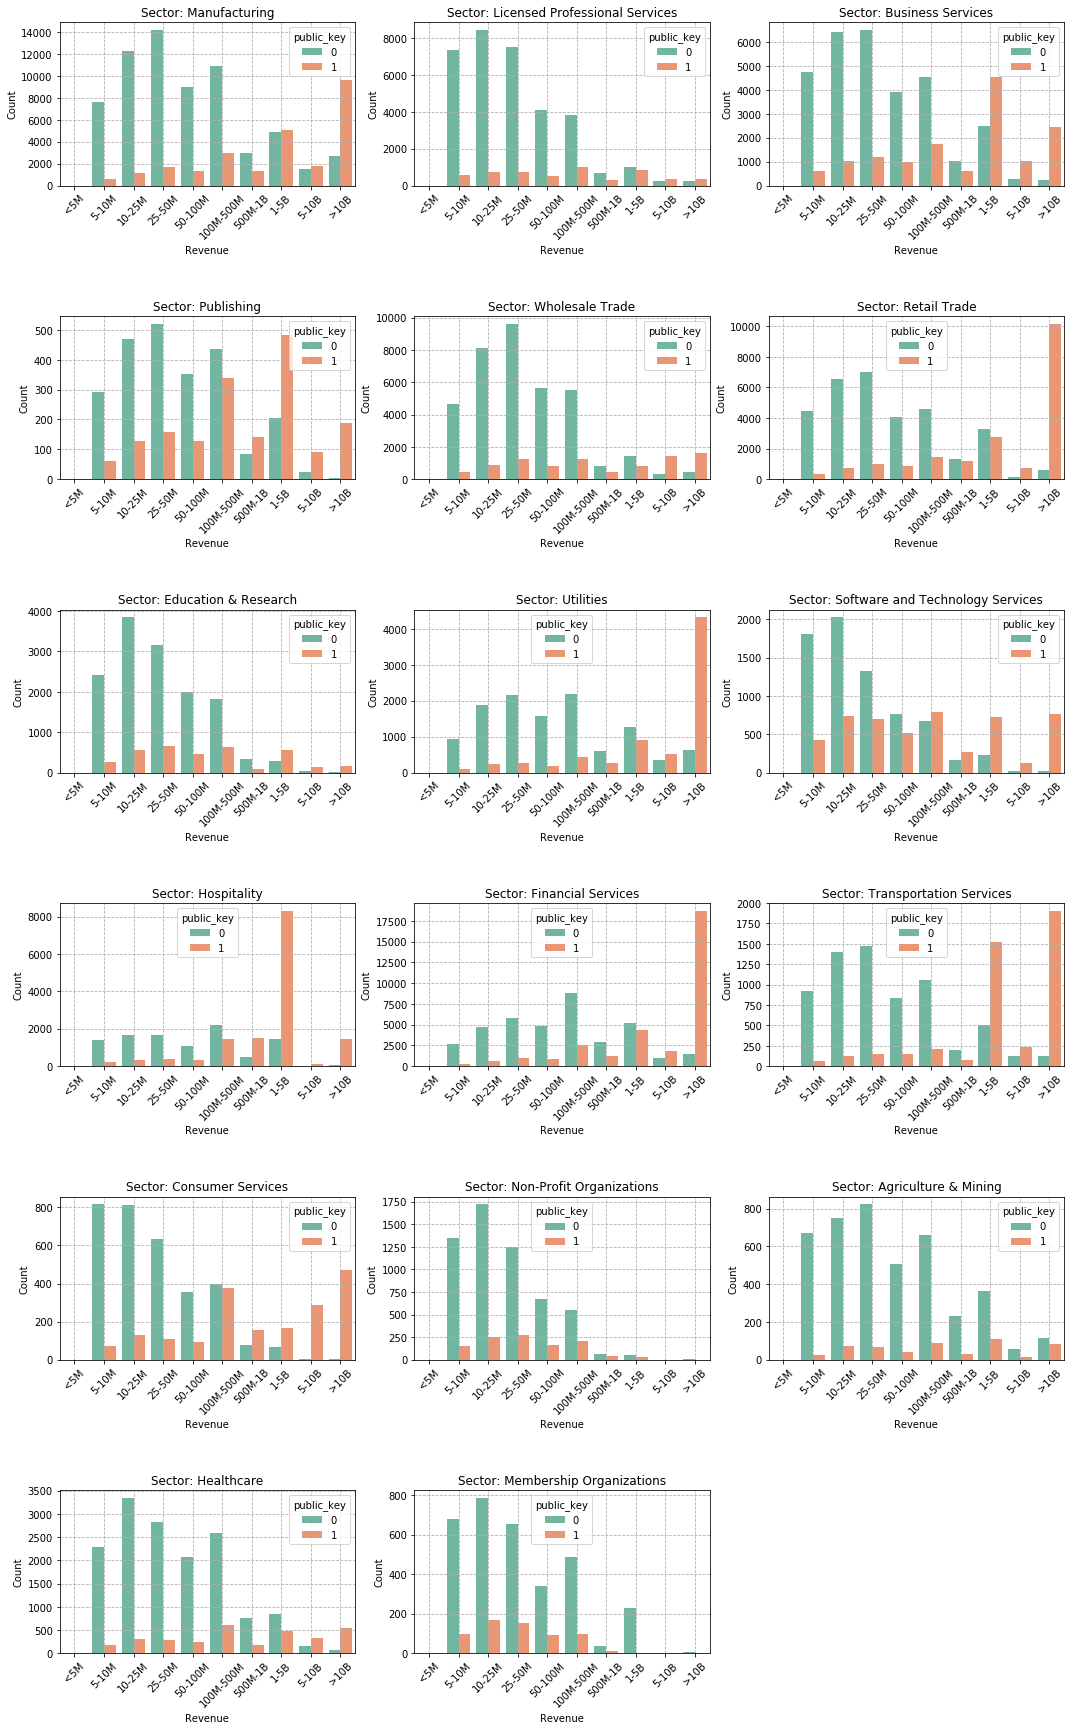

In [47]:
fig = plt.figure(figsize = (18, 30))
fig.subplots_adjust(hspace = 0.8)

for i in range(1, 18):
    ax = plt.subplot(6, 3, i)
    ax = sns.countplot(x = "revenue_label", hue = "public_key", data = agg_data.loc[(agg_data["cyence_sector"] == sectors[i]) & (agg_data["revenue_label"] != "<5M")], 
                   palette = sns.color_palette("Set2", n_colors=2))
    
    # settings
    plt.title("Sector: %s" % sectors[i])
    plt.xlabel("Revenue", fontsize = 10)
    plt.ylabel("Count", fontsize = 10)
    plt.xticks(fontsize = 10, rotation = 45)
    plt.yticks(fontsize = 10)
    plt.grid(ls = "--")

plt.savefig('by_sector.png')

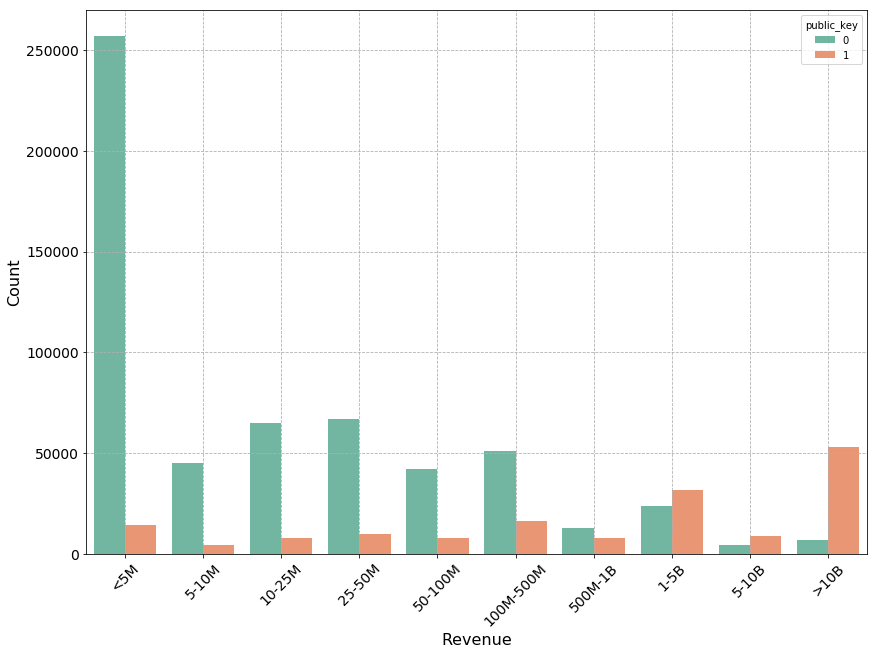

In [48]:
plt.figure(figsize = (14, 10))
ax = sns.countplot(x = "revenue_label", hue = "public_key", data = agg_data, 
                   palette = sns.color_palette("Set2", n_colors=2))

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)
plt.grid(ls = "--")

plt.savefig("public_key.png")

Scatter plot within the companies that have public keys. There seems to be no significant relationship between `revenue` and `max_public_key_length`. The top two outliers correspond to USPS (4928) and Paypal. 

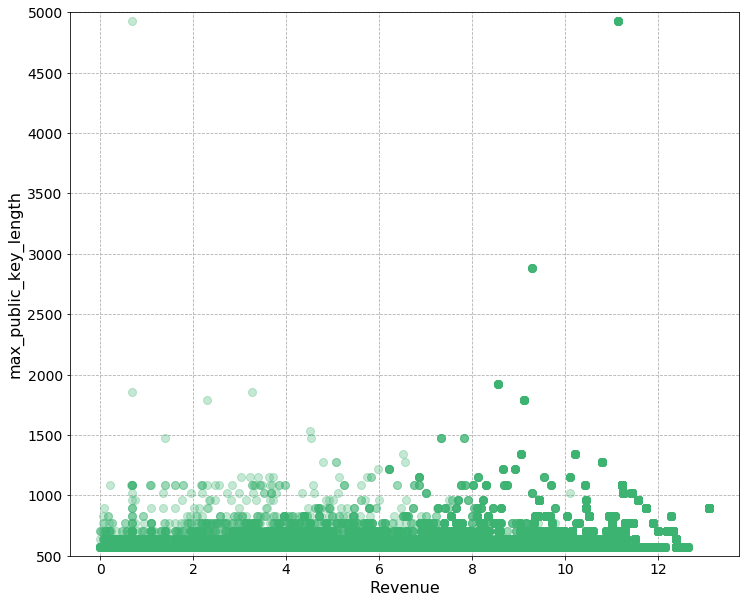

In [119]:
# Scatter plot
plt.figure(figsize = (12, 10))
temp_data = agg_data.loc[agg_data["public_key"] == 1]
# plt.plot(new_data['revenue'], new_data['agg_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 10)
plt.plot(np.log(temp_data['revenue'] + 1) , temp_data['max_public_key_length'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 8)

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("max_public_key_length", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim((500, 5000))
plt.grid(ls = "--")

In [133]:
# Check outliers: select company_name from er.company_info where cyence_id = 79809888;
agg_data.loc[(agg_data["public_key"] == 1) & (agg_data["max_public_key_length"] > 2000)]["cyence_id"].unique()

array([  3261245,  79809888, 797530243])

### Step 4: Correlation

In [56]:
# Create coverage plots
cyids_info, er_info = exploration.get_revenue_and_sector(data['cyence_id'].unique(), datetime.datetime(curr_year, curr_month, 1))

Retrieving ER information from company_info
Retrieving ER information from company_info_eu
Retrieving ER information from company_info_jp


In [57]:
exploration.create_breakdown_plots(cyids_info, er_info)

Creating the csvs..
Running the R plot scripts...
Could not execute R script:  Command '['RScript', '/Users/ygao/Desktop/Data Exploration/DKIM/shared/coverage_charts/CyidDistribution.R']' returned non-zero exit status 1


In [25]:
# Get correlation between variables- works best with <10
# Generates both Pearson and Spearman
plot.var_corr(data_subset)

NameError: name 'data_subset' is not defined

In [ ]:
# Correlation with revenue, employee, sector
query = 'SELECT cyence_id, revenue, employees, cyence_sector FROM er.company_info \
         WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
company_info = pd.read_sql_query(query, psql)

In [ ]:
# corr_info should contain numerical columns (possibly including revenue, employees, IPs) and 
# one column for cyence_sector
corr_info = pd.merge(company_info, data_subset)
plot.make_corr_chart(corr_info.drop('cyence_id', 1))